In [ ]:
!nvidia-smi

Thu May  5 03:57:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |  14586MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" #please put your GPU

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB5

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
# Set the TF deployment strategy - training on all visible GPUs in parallel
strategy = tf.distribute.MirroredStrategy()

1 Physical GPUs, 1 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
# Training image dimensions
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = (456, 456, 3) # EfficientNetB5 uses (456,456,3)
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# Define components of the save file
AUTHOR = 'AshwanthV'
MODEL = 'EfficientNetB5'
VERSION = '20210414_01'

#DATA_ROOT_FOLDER = os.path.join('/content/drive/MyDrive/hardhat/yes', '/content/drive/MyDrive/hardhat/no', 'data_presplit')


# Define folders to the images for training, validation, and test
#DATA_FOLDER = os.path.join(DATA_ROOT_FOLDER, "_".join(['data', str(IMG_WIDTH), 'split']))


IMAGE_TRAIN_FOLDER = '/content/drive/MyDrive/hardhat/train'
IMAGE_VAL_FOLDER = '/content/drive/MyDrive/hardhat/validation'
IMAGE_TEST_FOLDER = '/content/drive/MyDrive/hardhat/test'

IMAGE_TRAIN_FOLDER, IMAGE_VAL_FOLDER, IMAGE_TEST_FOLDER

('/content/drive/MyDrive/hardhat/train',
 '/content/drive/MyDrive/hardhat/validation',
 '/content/drive/MyDrive/hardhat/test')

In [ ]:
CLASS_NAMES = ['yes','no']

In [ ]:
# Define the training dataset
train_dir = IMAGE_TRAIN_FOLDER
validation_dir = IMAGE_VAL_FOLDER
test_dir = IMAGE_TEST_FOLDER

BATCH_SIZE = 128
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode='categorical',
                                             class_names=CLASS_NAMES,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode='categorical',
                                                  class_names=CLASS_NAMES,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            label_mode='categorical',
                                            class_names=CLASS_NAMES,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 591 files belonging to 2 classes.
Found 72 files belonging to 2 classes.
Found 67 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


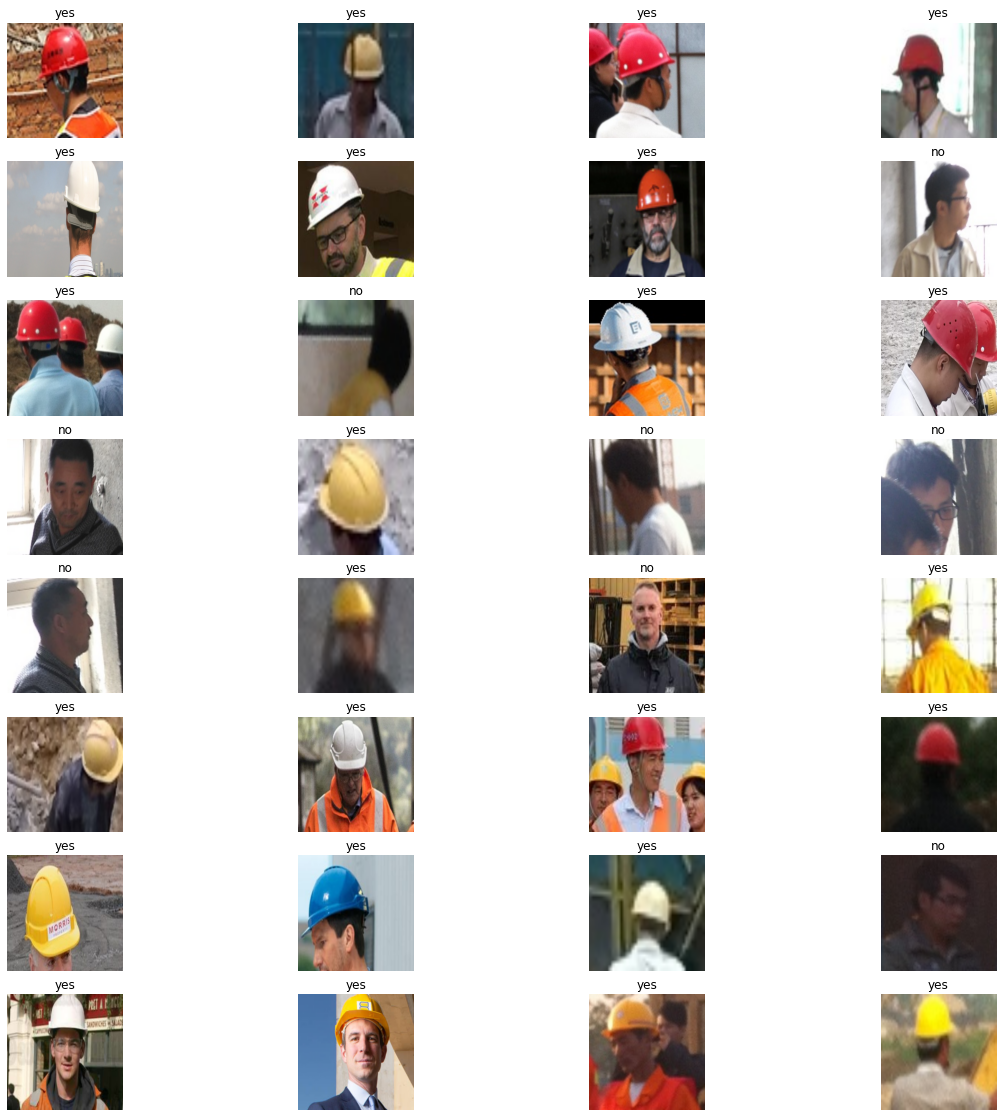

In [ ]:
# Show some of the sampled pictures
class_names = train_dataset.class_names
num_classes = len(class_names)

plt.figure(figsize=(20,20))
for images, labels in train_dataset.take(10):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
], name='data_augmentation')

Build the base model

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = preprocess_input(inputs)
    x = data_augmentation(x)
    
    # Create the base model from the pre-trained model EfficientNetB5
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                                      input_tensor=x,
                                                      include_top=False,
                                                      weights='imagenet')
    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
with strategy.scope():
    model = build_model(num_classes=num_classes)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 456, 456, 3)  0          ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 456, 456, 3)  0           ['data_augmentation[0][0]']      
                                                                                                  
 normalization_1 (Normalization  (None, 456, 456, 3)  7          ['rescaling_1[0][0]'] 

Train and evaluate the model

In [ ]:
with strategy.scope():
    loss0, accuracy0 = model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.1f}%".format(accuracy0 * 100))

1/1 [==============================] - 17s 17s/step - loss: 0.6527 - accuracy: 0.5694
initial loss: 0.65
initial accuracy: 56.9%


In [ ]:
initial_epochs = 50

filepath = '/content/drive/MyDrive/hardhat'.join([AUTHOR, MODEL, VERSION, 'initial.h5'])
checkpoint = ModelCheckpoint(filepath=filepath, mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

tf.debugging.set_log_device_placement(True)
with strategy.scope():
    history = model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=validation_dataset,
                        callbacks=callbacks_list)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7800
Epoch 1: val_accuracy improved from -inf to 0.73611, saving model to AshwanthV/content/drive/MyDrive/hardhatEfficientNetB5/content/drive/MyDrive/hardhat20210414_01/content/drive/MyDrive/hardhatinitial.h5
5/5 [==============================] - 43s 5s/step - loss: 0.6201 - accuracy: 0.7800 - val_loss: 0.6047 - val_accuracy: 0.7361
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.9340
Epoch 2: val_accuracy did not improve from 0.73611
5/5 [==============================] - 19s 4s/step - loss: 0.2861 - accuracy: 0.9340 - val_loss: 1.4861 - val_accuracy: 0.6944
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9560
Epoch 3: val_accuracy did not improve from 0.73611
5/5 [==============================] - 19s 4s/step - loss: 0.2469 - accuracy: 0.9560 - val_loss: 1.8291 - val_accuracy: 0.6944
Epoch 4/50
5/5 [=====================

Model performance curves

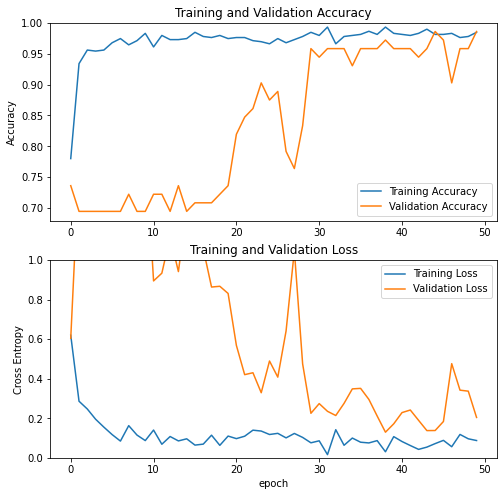

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine tune the model

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 50 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

Continuing the fine-tune training

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

filepath = '/content/drive/MyDrive/hardhat'.join([AUTHOR, MODEL, VERSION, 'finetune.h5'])
checkpoint = ModelCheckpoint(filepath=filepath, mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 50/100
INFO:tensorflow:Error reported to Coordinator: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/coordinator.py", line 293, in stop_on_exception
    yield
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/mirrored_run.py", line 204, in _call_for_each_replica
    t.has_paused.wait()
  File "/usr/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt


KeyboardInterrupt: ignored

Evaluate the improvements to the model after the fine-tuning

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 13s 13s/step - loss: 0.0238 - accuracy: 0.9851
Test accuracy : 0.9850746393203735


In [ ]:
dataset = test_dataset
for i, element in enumerate(dataset):
    print('Batch', i)
    image_batch, label_batch = element
    predictions = model.predict_on_batch(image_batch)

    # Obtain the index where the softmax predicted the class
    predictions_idx = np.argmax(predictions, axis=1)
    label_idx = np.argmax(label_batch, axis=1)

    print('Predictions:\n', predictions_idx)
    print('Labels:\n', label_idx)

Batch 0
Predictions:
 [0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0]
Labels:
 [0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0]


Predictions:
 [0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0]
Labels:
 [0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0]


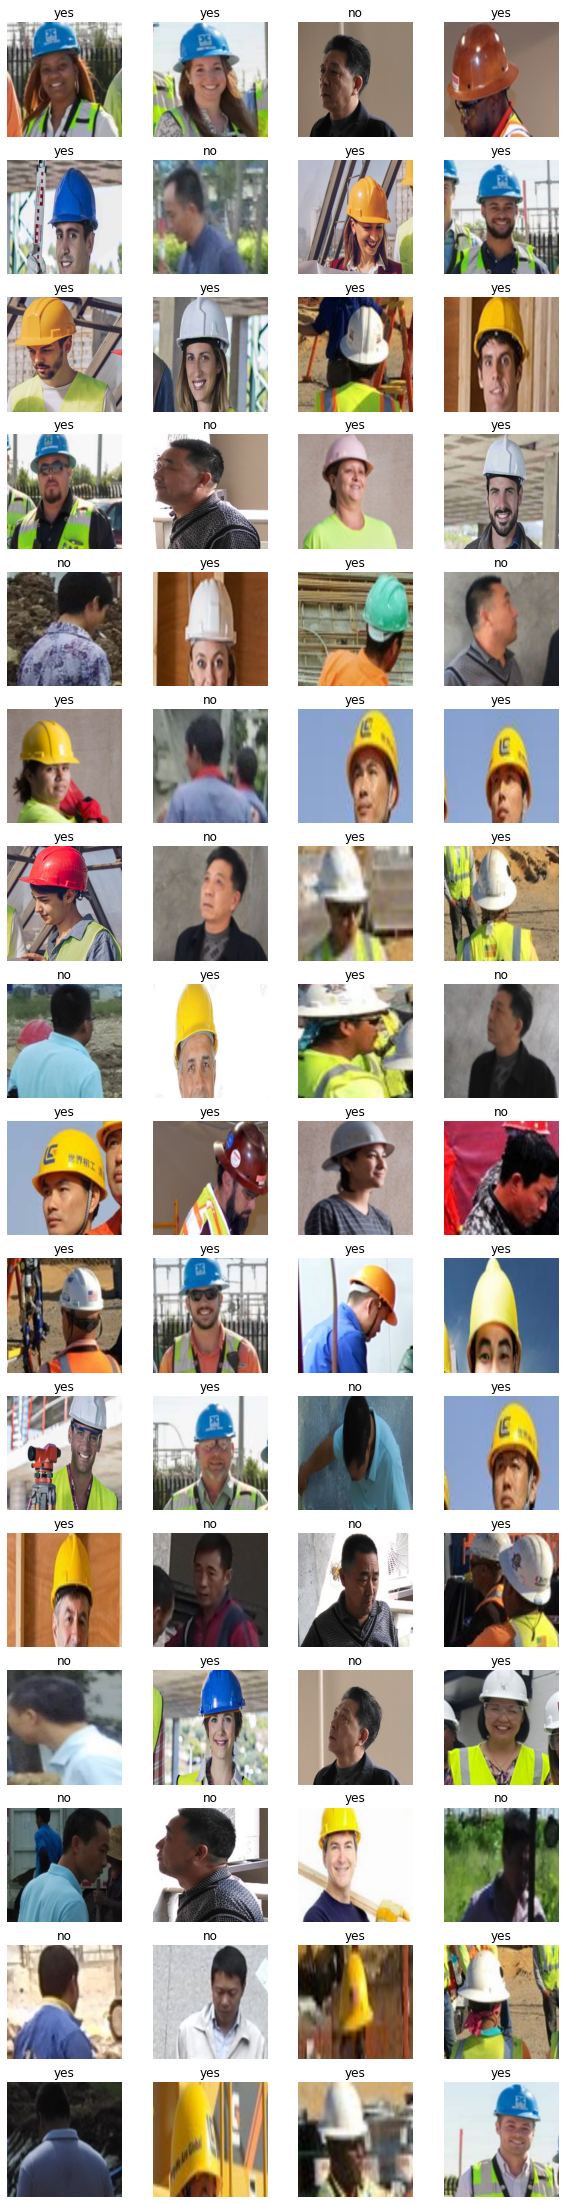

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Obtain the index where the softmax predicted the class
predictions_idx = np.argmax(predictions, axis=1)
label_idx = np.argmax(label_batch, axis=1)

print('Predictions:\n', predictions_idx)
print('Labels:\n', label_idx)

plt.figure(figsize=(10, 40))
for i in range(64):
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions_idx[i]])
    plt.axis("off")

In [ ]:
from keras.models import model_from_json

In [ ]:
json_model = model.to_json()

In [ ]:
with open('/content/drive/MyDrive/hardhat/model1.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
model.save_weights('/content/drive/MyDrive/hardhat/model1.h5')

In [ ]:
model.save('/content/drive/MyDrive//hardhat/model1'.join([MODEL, VERSION]))

KeyboardInterrupt: ignored